In [1]:
import os

In [6]:
dataset_path = r'C:\Users\sajid\ANISA\Machine learning projects\breast cancer'

In [7]:
num_benign_images = len(os.listdir(os.path.join(dataset_path, 'BENIGN')))
num_malignant_images = len(os.listdir(os.path.join(dataset_path, 'MALIGNANT')))

In [8]:
print("Number of benign images:", num_benign_images)
print("Number of malignant images:", num_malignant_images)

Number of benign images: 566
Number of malignant images: 494


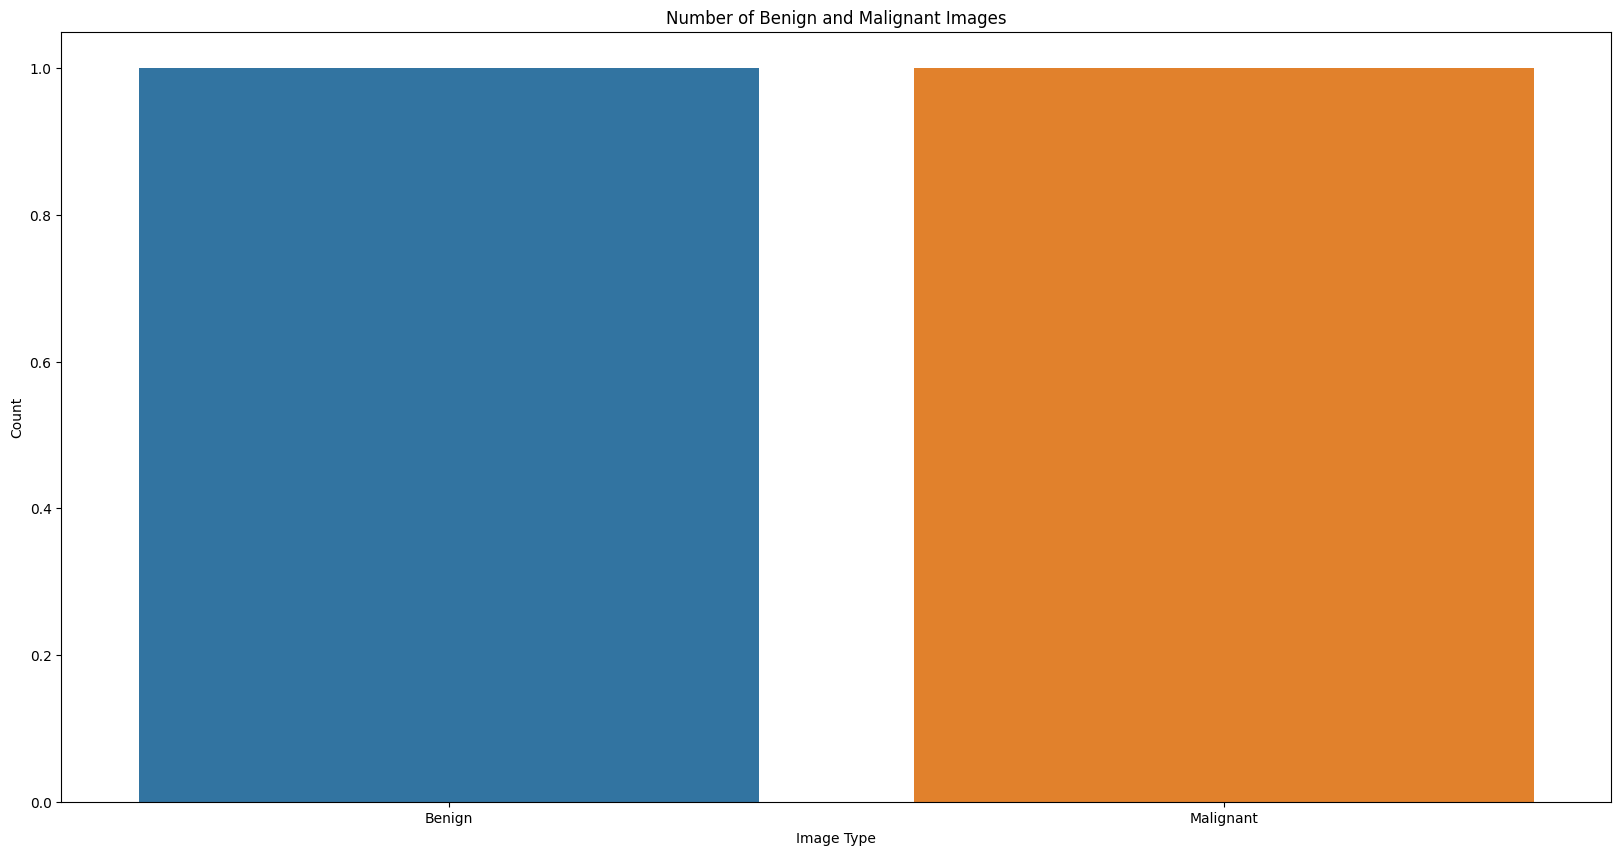

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


labels = ['Benign', 'Malignant']
counts = [num_benign_images, num_malignant_images]

plt.figure(figsize=(20, 10))
sns.countplot(x=labels)
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of Benign and Malignant Images')

plt.show()

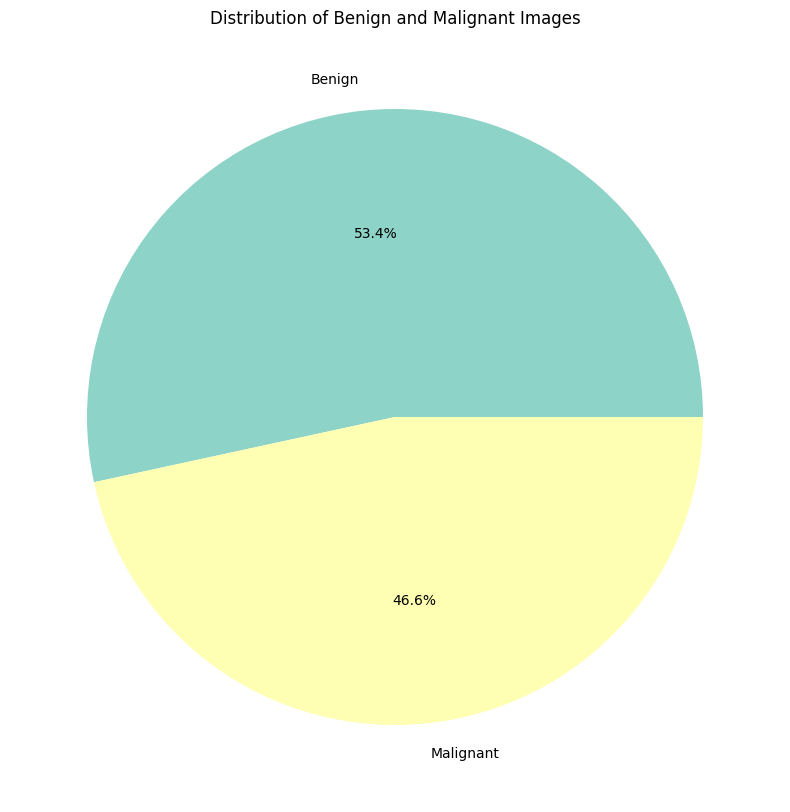

In [10]:
plt.figure(figsize=(10, 10))
sns.set_palette("Set3") 
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Benign and Malignant Images')

plt.show()

In [11]:
benign_path = os.path.join(dataset_path, 'BENIGN')
malignant_path = os.path.join(dataset_path, 'MALIGNANT')

In [13]:
benign_files = os.listdir(benign_path)

In [14]:
import cv2

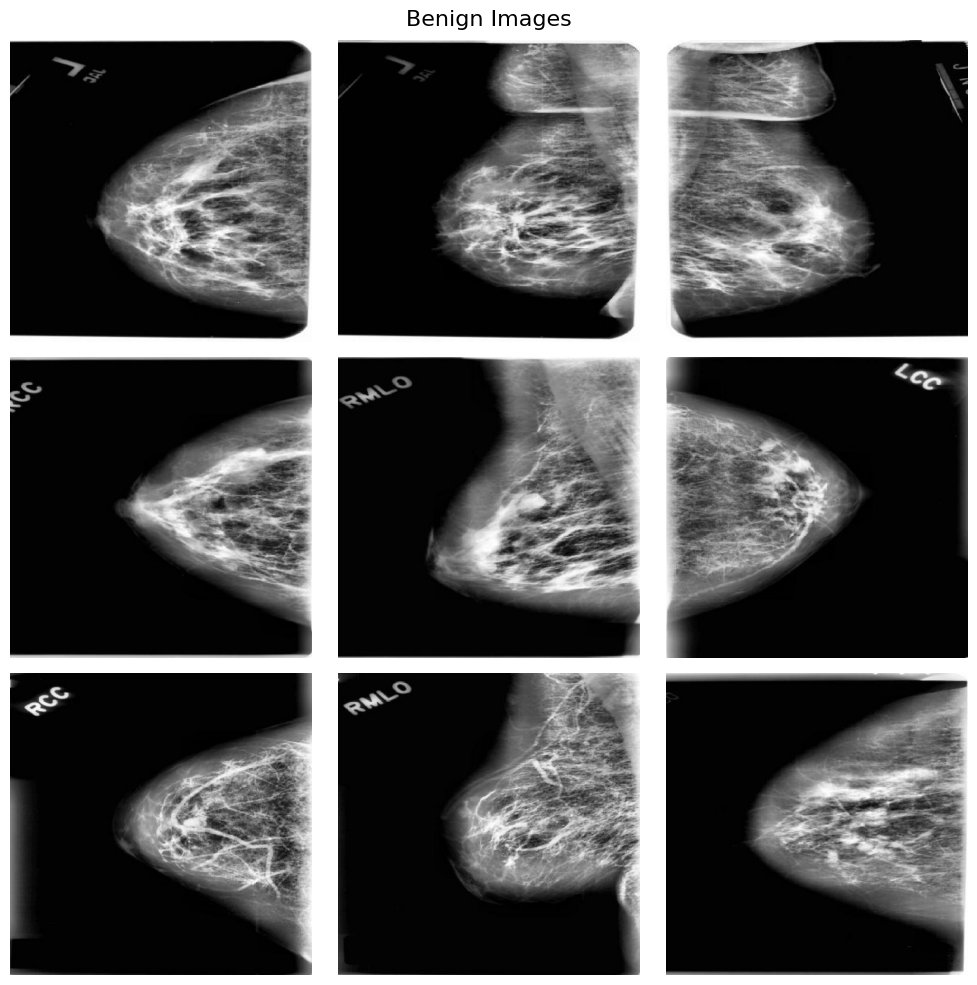

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Benign Images', fontsize=16)
axes = axes.ravel()

for i, image_file in enumerate(benign_files[:9]):
    image_path = os.path.join(benign_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
malignant_files = os.listdir(malignant_path)

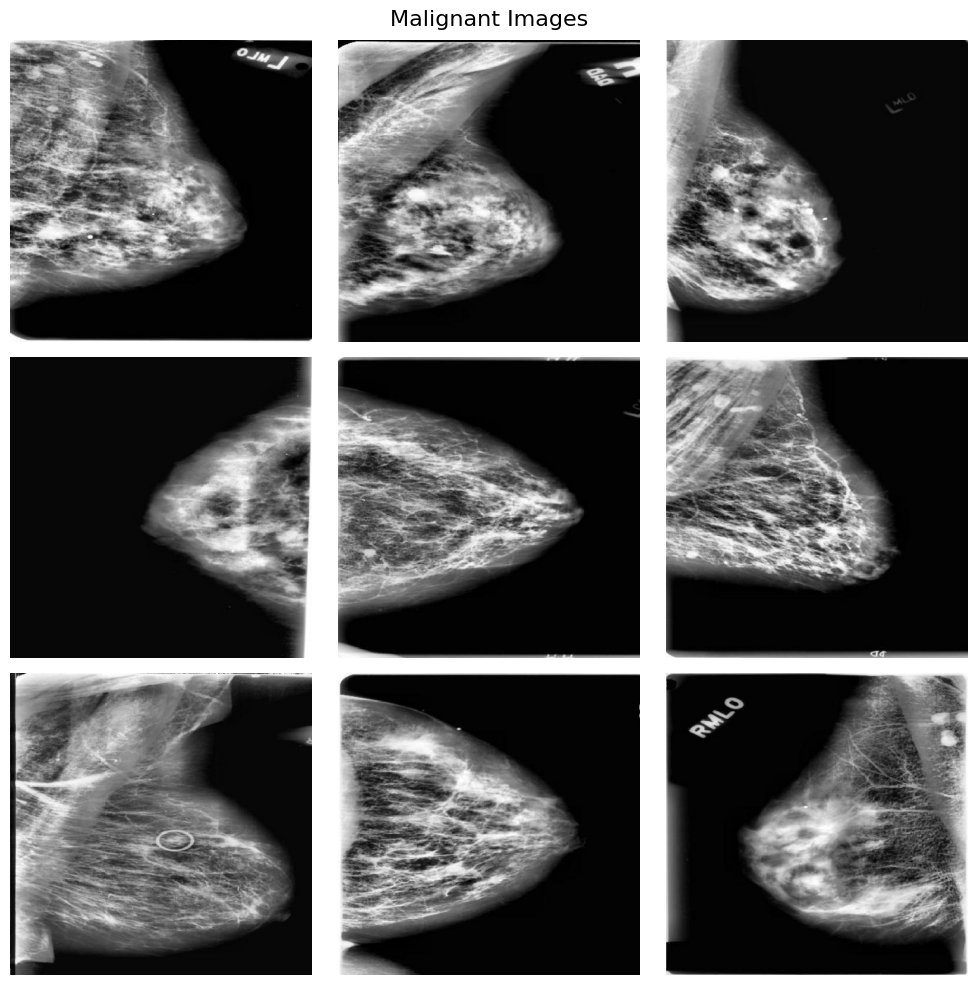

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Malignant Images', fontsize=16)
axes = axes.ravel()

for i, image_file in enumerate(malignant_files[:9]):
    image_path = os.path.join(malignant_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
image_shape = (28, 28, 1)
latent_dim = 100

In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.optimizers import Adam

In [20]:
def build_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))
    return model

In [21]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=image_shape))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [22]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [23]:
def load_dataset():
    images = []
    classes = ['BENIGN', 'MALIGNANT']
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)
        
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                print(f"Failed to load image: {image_path}")
                continue
            
            image = cv2.resize(image, image_shape[:2])
            image = image.reshape(image_shape)
            image = image.astype(np.float32) / 255.0
            images.append(image)
    
    images = np.array(images)
    return images

In [24]:
def preprocess_images(images):
    processed_images = []
    for image in images:
        # Resize image to (28, 28)
        resized_image = cv2.resize(image, (28, 28))
        # Normalize image values to [-1, 1]
        normalized_image = resized_image / 255.0 * 2 - 1
        processed_images.append(normalized_image)
    processed_images = np.array(processed_images)
    return processed_images

In [25]:
def generate_fake_samples(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    fake_images = generator.predict(noise)
    # Resize fake images to (28, 28)
    resized_fake_images = []
    for fake_image in fake_images:
        resized_fake_image = cv2.resize(fake_image, (28, 28))
        resized_fake_images.append(resized_fake_image)
    resized_fake_images = np.array(resized_fake_images)
    return resized_fake_images

In [26]:
# Train the GAN
def train_gan(X_train, epochs, batch_size):
    # Build the generator and discriminator models
    generator = build_generator()
    discriminator = build_discriminator()
    
    # Compile the discriminator model
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    # Build the GAN model
    gan = build_gan(generator, discriminator)
    
    # Compile the GAN model
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Adversarial ground truths
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # Training loop
    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        fake_images = generate_fake_samples(generator, batch_size)
        
        discriminator_loss_real = discriminator.train_on_batch(real_images, real)
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, fake)
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = gan.train_on_batch(noise, real)
        
        # Print the progress
        print(f"Epoch {epoch+1}/{epochs} - Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")
    
    # Save the generator model
    generator.save('generator_model.h5')

In [27]:
images = load_dataset()

preprocessed_images = preprocess_images(images)

epochs = 200
batch_size = 32
train_gan(preprocessed_images, epochs, batch_size)

1/1 [==============================] - 6s 6s/step
Epoch 1/200 - Discriminator Loss: 0.7580747306346893, Generator Loss: 0.6922774314880371
1/1 [==============================] - 5s 5s/step
Epoch 2/200 - Discriminator Loss: 0.4449383467435837, Generator Loss: 0.6343563795089722
1/1 [==============================] - 5s 5s/step
Epoch 3/200 - Discriminator Loss: 0.39797713700681925, Generator Loss: 0.57840895652771
1/1 [==============================] - 3s 3s/step
Epoch 4/200 - Discriminator Loss: 0.6273191500040411, Generator Loss: 0.6132762432098389
1/1 [==============================] - 2s 2s/step
Epoch 5/200 - Discriminator Loss: 0.6683278632641532, Generator Loss: 0.4019528329372406
1/1 [==============================] - 3s 3s/step
Epoch 6/200 - Discriminator Loss: 0.890720647430328, Generator Loss: 0.2884718179702759
1/1 [==============================] - 2s 2s/step
Epoch 7/200 - Discriminator Loss: 1.0262349158363122, Generator Loss: 0.23782432079315186
1/1 [=======================

1/1 [==============================] - 2s 2s/step
Epoch 60/200 - Discriminator Loss: 0.22459878772497177, Generator Loss: 1.3323822021484375
1/1 [==============================] - 3s 3s/step
Epoch 61/200 - Discriminator Loss: 0.3726199120283127, Generator Loss: 1.2088747024536133
1/1 [==============================] - 3s 3s/step
Epoch 62/200 - Discriminator Loss: 0.30463884957134724, Generator Loss: 1.2939685583114624
1/1 [==============================] - 3s 3s/step
Epoch 63/200 - Discriminator Loss: 0.2639096872881055, Generator Loss: 1.3248738050460815
1/1 [==============================] - 3s 3s/step
Epoch 64/200 - Discriminator Loss: 0.34658939950168133, Generator Loss: 1.182552695274353
1/1 [==============================] - 2s 2s/step
Epoch 65/200 - Discriminator Loss: 0.3200078122317791, Generator Loss: 1.2904810905456543
1/1 [==============================] - 2s 2s/step
Epoch 66/200 - Discriminator Loss: 0.37094972282648087, Generator Loss: 1.1905536651611328
1/1 [============

1/1 [==============================] - 2s 2s/step
Epoch 119/200 - Discriminator Loss: 0.43032192531973124, Generator Loss: 1.556160569190979
1/1 [==============================] - 2s 2s/step
Epoch 120/200 - Discriminator Loss: 0.306831419467926, Generator Loss: 1.5584533214569092
1/1 [==============================] - 2s 2s/step
Epoch 121/200 - Discriminator Loss: 0.2879348360002041, Generator Loss: 1.9942994117736816
1/1 [==============================] - 2s 2s/step
Epoch 122/200 - Discriminator Loss: 0.2795481886714697, Generator Loss: 1.6082370281219482
1/1 [==============================] - 2s 2s/step
Epoch 123/200 - Discriminator Loss: 0.2689147815108299, Generator Loss: 1.6346299648284912
1/1 [==============================] - 2s 2s/step
Epoch 124/200 - Discriminator Loss: 0.27444401383399963, Generator Loss: 1.6021335124969482
1/1 [==============================] - 2s 2s/step
Epoch 125/200 - Discriminator Loss: 0.38704246608540416, Generator Loss: 1.4015121459960938
1/1 [=======

1/1 [==============================] - 2s 2s/step
Epoch 177/200 - Discriminator Loss: 0.45970256024156697, Generator Loss: 2.4863905906677246
1/1 [==============================] - 2s 2s/step
Epoch 178/200 - Discriminator Loss: 0.34570488418103196, Generator Loss: 2.8916923999786377
1/1 [==============================] - 2s 2s/step
Epoch 179/200 - Discriminator Loss: 0.3456112644635141, Generator Loss: 3.6032984256744385
1/1 [==============================] - 2s 2s/step
Epoch 180/200 - Discriminator Loss: 0.21177127328701317, Generator Loss: 4.096863746643066
1/1 [==============================] - 3s 3s/step
Epoch 181/200 - Discriminator Loss: 0.1118706576526165, Generator Loss: 3.969008207321167
1/1 [==============================] - 2s 2s/step
Epoch 182/200 - Discriminator Loss: 0.18066801130771637, Generator Loss: 3.8253800868988037
1/1 [==============================] - 2s 2s/step
Epoch 183/200 - Discriminator Loss: 0.14369523548521101, Generator Loss: 3.5907294750213623
1/1 [=====

C:\Users\sajid\.conda\envs\myenv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 6s 6s/step


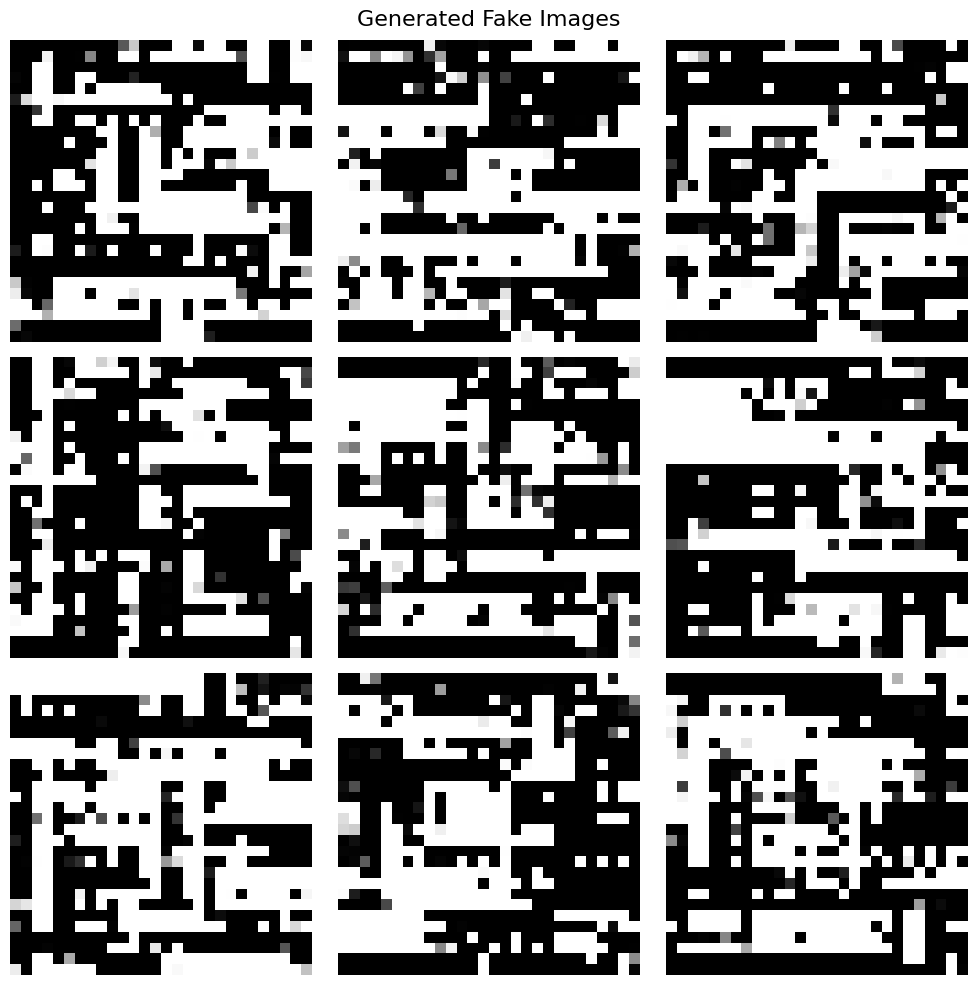

In [28]:
from tensorflow import keras
# Generate fake images using the trained generator
def generate_images(generator, num_images):
    # Generate random noise as input for the generator
    noise = np.random.randn(num_images, 100)
    
    # Generate fake images
    generated_images = generator.predict(noise)
    
    return generated_images

# Load the trained generator model
generator = keras.models.load_model('generator_model.h5')

# Generate and display fake images
num_images = 9
fake_images = generate_images(generator, num_images)

# Rescale pixel values from [-1, 1] to [0, 1]
fake_images = (fake_images + 1) / 2.0

# Create a grid of subplots to display the fake images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Generated Fake Images', fontsize=16)

# Plot each fake image in a subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i], cmap='gray')
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()